**Prueba técnica Data Scientist**

**1. Cargue de librerías**

In [ ]:
#Cargue de librerias
conda install pyarrow -c conda-forge

In [ ]:
pip install imbalanced-learn
pip install xgboost

In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier,plot_importance

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**2. Lectura de bases en formato parquet**

In [4]:
# Lectura de bases de datos 
# --> Transacciones/Transferencias: Aportes y retiros DIARIOS por CONTRATO y por PLAN PRODUCTO en 22 meses.
df1 = pd.read_parquet("0transferencias.parquet", engine="pyarrow")

# --> Saldos: Saldo a final de MES por CLIENTE, CONTRATO y PLAN PRODUCTO en 22 meses.
df2 = pd.read_parquet("0saldos.parquet", engine="pyarrow")

# --> Clientes: Información demográfica del CLIENTE.
df3 = pd.read_parquet("0clientes.parquet", engine="pyarrow")
df1

,NroEvento,NroTransaccion,FechaEfectiva,FechaProceso,ValorNeto,Usuario,CodDestino,CodTipoGiro,CodBancoDestinoACH,CodBancoSkandia,TipoCtaACH,TipoOper,EstadoReverso,Contrato,PlanProducto
0,210729985596,210729007960,2021-07-27,2021-07-29,-7921800.0,None,0,3,None,None,None,Directo,R,8774634,7256
1,210729986040,210729008404,2021-07-27,2021-07-29,-7850000.0,None,0,3,None,None,None,Directo,R,8774634,7256
2,210729985625,210729007989,2021-07-28,2021-07-29,-6000000.0,None,0,3,None,None,None,Directo,R,8774634,7256
3,210729985594,210729007958,2021-07-28,2021-07-29,-8000000.0,None,0,3,None,None,None,Directo,R,8774634,7256
4,210729986049,210729008413,2021-07-22,2021-07-29,-8256019.0,None,0,3,None,None,None,Directo,R,8774634,7256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491825,220923336731,220923361557,2022-09-23,2022-09-23,-5000000.0,MFTAXBEN,1,2,19,None,C,Traslado,,7678955,7256
491826,220923336073,220923360894,2022-09-23,2022-09-23,-20000000.0,MFCOPLU,1,2,07,None,A,Directo,,6916388,5172
491827,220923335804,220923360625,2022-09-23,2022-09-23,-24000000.0,MFTAXBEN,1,2,51,None,A,Directo,,3107778,7256
491828,220924338558,220924363388,2022-09-23,2022-09-23,100000000.0,None,0,3,None,None,None,Directo,,8688704,5172


In [ ]:
# A continuación se realiza una exploración de cada una de las bases donde se muestran los formatos que se tienen para
# cada una de las variables y algunos estadísticos de las variables numéricas

In [5]:
df1.columns

Index(['NroEvento', 'NroTransaccion', 'FechaEfectiva', 'FechaProceso',
       'ValorNeto', 'Usuario', 'CodDestino', 'CodTipoGiro',
       'CodBancoDestinoACH', 'CodBancoSkandia', 'TipoCtaACH', 'TipoOper',
       'EstadoReverso', 'Contrato', 'PlanProducto'],
      dtype='object')

In [6]:
df1.dtypes

NroEvento                     object
NroTransaccion                object
FechaEfectiva         datetime64[ns]
FechaProceso          datetime64[ns]
ValorNeto                    float64
Usuario                       object
CodDestino                    object
CodTipoGiro                    int64
CodBancoDestinoACH            object
CodBancoSkandia               object
TipoCtaACH                    object
TipoOper                      object
EstadoReverso                 object
Contrato                       int64
PlanProducto                   int64
dtype: object

In [7]:
df1["ValorNeto"].describe()

count    4.918300e+05
mean    -6.289186e+05
std      9.267685e+07
min     -1.023084e+10
25%     -1.000000e+06
50%      2.121960e+05
75%      2.000000e+06
max      1.023084e+10
Name: ValorNeto, dtype: float64

In [ ]:
df2.columns

In [ ]:
df2.dtypes

In [ ]:
df2.describe()

In [ ]:
df3.columns

In [ ]:
df3.dtypes

**3. Depuración base de datos**

**3.1 Base de datos 3 >> CLIENTES**

In [9]:
#Validación de clientes repetidos

print("La base original cuenta con un total de: " + str(len(df3)) + " registros.")

print("La cantidad de clientes únicos corresponde a: " + str(df3["NroDocum"].nunique()))

La base original cuenta con un total de: 108092 registros.
La cantidad de clientes únicos corresponde a: 108065


In [10]:
#Eliminación de clientes repetidos
df3_ = df3.drop_duplicates(subset=["NroDocum"], keep="first")
df3_

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,NroDocum
0,C,"BOGOTA D.C., BOGOTA",1954-12-16,E,1092070504
1,C,"BOGOTA D.C., BOGOTA",1969-08-04,E,1097627287
2,C,"BOGOTA D.C., BOGOTA",1961-08-15,T,1066619616
3,C,"BOGOTA D.C., BOGOTA",1986-02-08,T,1079454835
4,C,"MEDELLIN, ANTIOQUIA",1981-01-15,E,1199126816
...,...,...,...,...,...
108087,C,"BOGOTA D.C., BOGOTA",1977-09-25,E,1077819263
108088,C,"BOGOTA D.C., BOGOTA",1964-09-30,E,1050991361
108089,C,"LA MESA, CUNDINAMARCA",1964-11-23,E,1117842187
108090,C,"BOGOTA D.C., BOGOTA",1976-07-01,T,1065109336


In [11]:
df3_["NroDocum"]=df3_["NroDocum"].astype("str")

In [22]:
df3_["year_birth"] = df3_["FecNacim"].dt.year

In [23]:
df3_["Edad"]=2022-df3_["year_birth"]
df3_.sort_values(by=["Edad"])

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,NroDocum,year_birth,Edad,Rango_Edad
86362,C,"BOGOTA D.C., BOGOTA",2050-01-01,E,1195468772,2050.0,-28.0,41-60
65730,C,"CALI,VALLE DEL CAUCA",2050-01-01,E,1076589352,2050.0,-28.0,41-60
14394,E,"BOGOTA D.C., BOGOTA",2050-01-01,E,1057396236,2050.0,-28.0,41-60
31838,C,"BUCARAMANGA,SANTANDER",2050-01-01,E,1027350975,2050.0,-28.0,41-60
11883,R,"ENVIGADO, ANTIOQUIA",2020-02-29,E,1010614570,2020.0,2.0,<=20
...,...,...,...,...,...,...,...,...
18389,C,"CALI, VALLE DEL CAUCA",1900-01-01,T,1040678684,1900.0,122.0,>60
18470,C,"BOGOTA D.C., BOGOTA",1900-06-12,S,1090528895,1900.0,122.0,>60
30502,C,"CALI, VALLE DEL CAUCA",1900-01-01,T,1133324757,1900.0,122.0,>60
25389,C,"BOGOTA D.C., BOGOTA",1900-01-01,T,1167812390,1900.0,122.0,>60


In [24]:
df3_["Edad"] = df3_["Edad"].where(df3_["Edad"].ge(0))
df3_.sort_values(by=["Edad"])

,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,NroDocum,year_birth,Edad,Rango_Edad
11883,R,"ENVIGADO, ANTIOQUIA",2020-02-29,E,1010614570,2020.0,2.0,<=20
90018,R,"BOGOTA D.C., BOGOTA",2018-09-05,E,1195785133,2018.0,4.0,<=20
59380,R,"BOGOTA D.C., BOGOTA",2017-06-07,E,1112590988,2017.0,5.0,<=20
26788,R,"BARRANQUILLA, ATLANTICO",2016-01-13,E,1129723601,2016.0,6.0,<=20
101302,R,"BOGOTA D.C., BOGOTA",2016-01-14,E,1184038752,2016.0,6.0,<=20
...,...,...,...,...,...,...,...,...
14394,E,"BOGOTA D.C., BOGOTA",2050-01-01,E,1057396236,2050.0,NaN,41-60
31838,C,"BUCARAMANGA,SANTANDER",2050-01-01,E,1027350975,2050.0,NaN,41-60
63182,,"BOGOTA D.C., BOGOTA",NaT,E,1065281692,NaN,NaN,41-60
65730,C,"CALI,VALLE DEL CAUCA",2050-01-01,E,1076589352,2050.0,NaN,41-60


In [25]:
# Existe un registro sin fecha de nacimiento y 4 clientes con fecha de nacimiento futura (año 2050),
# para estos registro se imputó la edad con la mediana.

imputer = SimpleImputer(missing_values=np.NaN, strategy="median")
 
df3_["Edad"] = imputer.fit_transform(df3_["Edad"].values.reshape(-1,1))[:,0]

In [26]:
df3_["Edad"]=df3_["Edad"].astype("int")

In [27]:
df3_.loc[df3_["Edad"]<=20, "Rango_Edad"] = "<=20"
df3_.loc[df3_["Edad"].between(20,40), "Rango_Edad"] = "21-40"
df3_.loc[df3_["Edad"].between(40,60), "Rango_Edad"] = "41-60"
df3_.loc[df3_["Edad"]>60, "Rango_Edad"] = ">60"

In [28]:
df3_["Rango_Edad"].isna().sum()

0

**3.2 Base de datos 2 >> SALDOS**

In [31]:
# Se crea la tabla "valida" para identificar la cantidad de registros con saldo cero para los 22 meses

valida = df2[(df2["SALDO_202101"] == 0) & (df2["SALDO_2021O2"] == 0) & (df2["SALDO_2021O3"] == 0) &
          (df2["SALDO_2021O4"] == 0) & (df2["SALDO_2021O5"] == 0) & (df2["SALDO_2021O6"] == 0) &
          (df2["SALDO_2021O7"] == 0) & (df2["SALDO_2021O8"] == 0) & (df2["SALDO_2021O9"] == 0) &
          (df2["SALDO_202110"] == 0) & (df2["SALDO_202111"] == 0) & (df2["SALDO_202112"] == 0) &
          (df2["SALDO_202201"] == 0) & (df2["SALDO_202202"] == 0) & (df2["SALDO_202203"] == 0) &
          (df2["SALDO_202204"] == 0) & (df2["SALDO_202205"] == 0) & (df2["SALDO_202206"] == 0) &
          (df2["SALDO_202207"] == 0) & (df2["SALDO_202208"] == 0) & (df2["SALDO_202209"] == 0) &
          (df2["SALDO_202210"] == 0)]

print("La cantidad de registros que se encuentran en ceros para los 22 periodos es de:",len(valida))

La cantidad de registros que se encuentran en ceros para los 22 periodos es de: 164562


In [33]:
# Eliminar de la base de saldos aquellas filas en donde las 22 variables de saldo se encuentren en cero
# Esta eliminación se realiza dado al ruido que pueden llegar a tener esos registros en el modelo de predicción.

df2_zero = df2[(df2["SALDO_202101"] != 0) | (df2["SALDO_2021O2"] != 0) | (df2["SALDO_2021O3"] != 0) |
          (df2["SALDO_2021O4"] != 0) | (df2["SALDO_2021O5"] != 0) | (df2["SALDO_2021O6"] != 0) |
          (df2["SALDO_2021O7"] != 0) | (df2["SALDO_2021O8"] != 0) | (df2["SALDO_2021O9"] != 0) |
          (df2["SALDO_202110"] != 0) | (df2["SALDO_202111"] != 0) | (df2["SALDO_202112"] != 0) |
          (df2["SALDO_202201"] != 0) | (df2["SALDO_202202"] != 0) | (df2["SALDO_202203"] != 0) |
          (df2["SALDO_202204"] != 0) | (df2["SALDO_202205"] != 0) | (df2["SALDO_202206"] != 0) |
          (df2["SALDO_202207"] != 0) | (df2["SALDO_202208"] != 0) | (df2["SALDO_202209"] != 0) |
          (df2["SALDO_202210"] != 0)]

In [35]:
# Creación de nueva variable que contiene el número de documento, el contrato y el planproducto concatenados

df2_zero["nro_con_plan"]=df2_zero["NroDocum"].astype("str") + "_" + df2_zero["Contrato"].astype("str") + "_" + df2_zero["PlanProducto"].astype("str")


In [36]:
# Consolidar información a nivel cliente+contrato+producto en la base de datos de saldos

df2_one = df2_zero.groupby("nro_con_plan").agg({"SALDO_202101":sum,"SALDO_2021O2":sum,"SALDO_2021O3":sum,"SALDO_2021O4":sum,
                                                "SALDO_2021O5":sum,"SALDO_2021O6":sum,"SALDO_2021O7":sum,"SALDO_2021O8":sum,
                                                "SALDO_2021O9":sum,"SALDO_202110":sum,"SALDO_202111":sum,"SALDO_202112":sum,
                                                "SALDO_202201":sum,"SALDO_202202":sum,"SALDO_202203":sum,"SALDO_202204":sum,
                                                "SALDO_202205":sum,"SALDO_202206":sum,"SALDO_202207":sum,"SALDO_202208":sum,
                                                "SALDO_202209":sum,"SALDO_202210":sum}).reset_index()

**3.3 Base de datos 1 >> TRANSACCIONES**

In [37]:
# Para unificar la ventana de tiempo (ene2021-oct2022), se eliminan de la base transacciones los registros previos 
# al año 2021.

df1["year_ef"] = df1["FechaEfectiva"].dt.year

df1_ = df1[(df1["year_ef"] == 2021) | (df1["year_ef"] == 2022)]

**4. Consolidación de información a nivel cliente**

In [38]:
# Para la base de transacciones se busca totalizar los montos registrados en la variable "ValorNeto" agrupados
# por año, mes, contrato y plan producto. La información del periodo (año, mes) se decidió tomar de la variable 
# "FechaEfectiva".

totalSum = df1_.groupby([df1_["FechaEfectiva"].dt.year.rename("year_ef"),
                       df1_["FechaEfectiva"].dt.month.rename("month_ef"),
                       "Contrato",
                       "PlanProducto"]).agg({"ValorNeto": sum}).reset_index()

In [39]:
# En este punto, se realiza la unión de la base de datos consolidada anteriormente junto a la información registrada 
# en la base df2 depurada, que contiene los saldos mensuales. 

mergxx = pd.merge(totalSum,df2_zero[["Contrato","PlanProducto","NroDocum"]],how="left",on=["Contrato","PlanProducto"])
mergxx

,year_ef,month_ef,Contrato,PlanProducto,ValorNeto,NroDocum
0,2021,1,10359,4899,10000000.0,1.050921e+09
1,2021,1,11595,4899,5200000.0,1.047148e+09
2,2021,1,12541,4899,7609529.0,1.152980e+09
3,2021,1,12973,3376,800000.0,1.096057e+09
4,2021,1,14150,8404,6000000.0,1.104760e+09
...,...,...,...,...,...,...
205546,2022,10,9991126,3376,-102476138.0,1.022823e+09
205547,2022,10,9991635,7256,-2500000.0,1.038316e+09
205548,2022,10,9992731,7256,4000000.0,1.012376e+09
205549,2022,10,9996808,7256,250000.0,1.040127e+09


In [41]:
# Ahora se filtran únicamente los registros con saldos, es decir, aquellos que se encuentran en las 2 bases de datos 
# que se cruzaron y para este caso son aquellos que tienen información en la variable "NroDocum".

mergxx = mergxx[mergxx["NroDocum"].notna()]
mergxx

,year_ef,month_ef,Contrato,PlanProducto,ValorNeto,NroDocum
0,2021,1,10359,4899,10000000.0,1.050921e+09
1,2021,1,11595,4899,5200000.0,1.047148e+09
2,2021,1,12541,4899,7609529.0,1.152980e+09
3,2021,1,12973,3376,800000.0,1.096057e+09
4,2021,1,14150,8404,6000000.0,1.104760e+09
...,...,...,...,...,...,...
205546,2022,10,9991126,3376,-102476138.0,1.022823e+09
205547,2022,10,9991635,7256,-2500000.0,1.038316e+09
205548,2022,10,9992731,7256,4000000.0,1.012376e+09
205549,2022,10,9996808,7256,250000.0,1.040127e+09


In [42]:
mergxx.dtypes

year_ef           int64
month_ef          int64
Contrato          int64
PlanProducto      int64
ValorNeto       float64
NroDocum        float64
dtype: object

In [43]:
mergxx["NroDocum"]=mergxx["NroDocum"].apply(int)

In [44]:
mergxx.dtypes

year_ef           int64
month_ef          int64
Contrato          int64
PlanProducto      int64
ValorNeto       float64
NroDocum          int64
dtype: object

In [45]:
mergxx["nro_con_plan"] = mergxx["NroDocum"].astype("str") + "_" + mergxx["Contrato"].astype("str") + "_" + mergxx["PlanProducto"].astype("str")
mergxx

,year_ef,month_ef,Contrato,PlanProducto,ValorNeto,NroDocum,nro_con_plan
0,2021,1,10359,4899,10000000.0,1050921348,1050921348_10359_4899
1,2021,1,11595,4899,5200000.0,1047147717,1047147717_11595_4899
2,2021,1,12541,4899,7609529.0,1152979803,1152979803_12541_4899
3,2021,1,12973,3376,800000.0,1096057493,1096057493_12973_3376
4,2021,1,14150,8404,6000000.0,1104760101,1104760101_14150_8404
...,...,...,...,...,...,...,...
205546,2022,10,9991126,3376,-102476138.0,1022823263,1022823263_9991126_3376
205547,2022,10,9991635,7256,-2500000.0,1038315774,1038315774_9991635_7256
205548,2022,10,9992731,7256,4000000.0,1012375548,1012375548_9992731_7256
205549,2022,10,9996808,7256,250000.0,1040127497,1040127497_9996808_7256


In [46]:
# Ahora se totaliza la información a nivel cliente+contrato+producto (nro_con_plan), año y mes

totalSum1 = mergxx.groupby(["nro_con_plan",
                            "year_ef",
                            "month_ef"]).agg({"ValorNeto": sum}).reset_index()

totalSum1

,nro_con_plan,year_ef,month_ef,ValorNeto
0,1000001634_9950268_4899,2021,1,-600000.0
1,1000001634_9950268_4899,2021,2,-600000.0
2,1000001634_9950268_4899,2021,3,-600000.0
3,1000001634_9950268_4899,2021,4,-600000.0
4,1000001634_9950268_4899,2021,5,1987950.0
...,...,...,...,...
205269,1199993307_1289932_4899,2021,7,-20000000.0
205270,1199993307_1289932_4899,2021,9,-1000000.0
205271,1199993307_1289932_4899,2021,10,-17000000.0
205272,1199993307_1289932_4899,2022,4,-8000000.0


In [47]:
# Creación de la variable "year_month_ef", concatenando el año y el mes de la transacción
totalSum1["year_month_ef"] = totalSum1["year_ef"].astype("str") + "_" + totalSum1["month_ef"].astype("str")
totalSum1

,nro_con_plan,year_ef,month_ef,ValorNeto,year_month_ef
0,1000001634_9950268_4899,2021,1,-600000.0,2021_1
1,1000001634_9950268_4899,2021,2,-600000.0,2021_2
2,1000001634_9950268_4899,2021,3,-600000.0,2021_3
3,1000001634_9950268_4899,2021,4,-600000.0,2021_4
4,1000001634_9950268_4899,2021,5,1987950.0,2021_5
...,...,...,...,...,...
205269,1199993307_1289932_4899,2021,7,-20000000.0,2021_7
205270,1199993307_1289932_4899,2021,9,-1000000.0,2021_9
205271,1199993307_1289932_4899,2021,10,-17000000.0,2021_10
205272,1199993307_1289932_4899,2022,4,-8000000.0,2022_4


In [48]:
# Uso de la función pivot que permite reorganizar la base de datos dejando la variable "year_month_ef" que antes
# mostraba cada una única columna que registraba todos los periodos de la base, en múltiples columnas en donde
# cada una registra la información de un único periodo.

totalSum1new = totalSum1.pivot(index="nro_con_plan", columns="year_month_ef", values="ValorNeto").reset_index()
totalSum1new

year_month_ef,nro_con_plan,2021_1,2021_10,2021_11,2021_12,2021_2,2021_3,2021_4,2021_5,2021_6,...,2022_1,2022_10,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9
0,1000001634_9950268_4899,-600000.0,1987950.0,-600000.0,-600000.0,-600000.0,-600000.0,-600000.0,1987950.0,-600000.0,...,-600000.0,-600000.0,2467200.0,-600000.0,2132940.0,-600000.0,-6.000000e+05,-600000.0,-600000.0,-600000.0
1,1000007479_2779865_8404,NaN,NaN,6000000.0,3000000.0,3000000.0,3000000.0,3000000.0,3000000.0,6000000.0,...,3000000.0,6000000.0,NaN,6000000.0,-97000000.0,3000000.0,3.000000e+06,3000000.0,3000000.0,202235748.0
2,1000014510_2040989_7256,NaN,5000000.0,5000000.0,5000000.0,5000000.0,3000000.0,0.0,-2500000.0,NaN,...,NaN,NaN,5000000.0,-2000000.0,3000000.0,-5000000.0,NaN,NaN,NaN,-3000000.0
3,1000014510_4583487_7256,NaN,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,NaN,NaN,...,NaN,NaN,5000000.0,NaN,5000000.0,NaN,NaN,NaN,NaN,NaN
4,1000031391_4481719_8404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51700000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23372,1199980600_3777506_3376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23373,1199985052_4566732_5172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.350000e+08,NaN,NaN,NaN
23374,1199985052_8304681_4899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25000000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,-50000000.0,-1.598679e+07,NaN,NaN,NaN
23375,1199993065_543432_8404,NaN,NaN,NaN,5000000.0,NaN,NaN,NaN,NaN,-4000000.0,...,-2528000.0,-8000000.0,-2610000.0,-2262000.0,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,-2610000.0,-8178000.0


In [50]:
# Consolidación de base transacciones (totalSum1new) + saldos a nivel cliente+contrato+planproducto(df2_)

mergxx2 = pd.merge(totalSum1new,df2_one,on=["nro_con_plan"])
mergxx2

,nro_con_plan,2021_1,2021_10,2021_11,2021_12,2021_2,2021_3,2021_4,2021_5,2021_6,...,SALDO_202201,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202209,SALDO_202210
0,1000001634_9950268_4899,-600000.0,1987950.0,-600000.0,-600000.0,-600000.0,-600000.0,-600000.0,1987950.0,-600000.0,...,4.999541e+07,5.090699e+07,4.823857e+07,5.024988e+07,4.843097e+07,4.897617e+07,5.040000e+07,4.914860e+07,0.0,4.967498e+07
1,1000007479_2779865_8404,NaN,NaN,6000000.0,3000000.0,3000000.0,3000000.0,3000000.0,3000000.0,6000000.0,...,1.304447e+08,1.304298e+08,1.365314e+08,3.699640e+07,3.937156e+07,4.217677e+07,4.542436e+07,5.096480e+07,0.0,2.548386e+08
2,1000014510_2040989_7256,NaN,5000000.0,5000000.0,5000000.0,5000000.0,3000000.0,0.0,-2500000.0,NaN,...,3.997053e+07,4.418434e+07,4.230180e+07,3.882531e+07,3.734295e+07,3.539777e+07,3.634069e+07,3.586996e+07,0.0,3.263579e+07
3,1000014510_4583487_7256,NaN,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,NaN,NaN,...,4.977641e+07,5.418399e+07,5.405085e+07,5.364563e+07,5.859193e+07,5.804290e+07,5.802978e+07,5.788506e+07,0.0,5.791023e+07
4,1000031391_4481719_8404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.533468e+07,8.505437e+07,8.509428e+07,8.465817e+07,8.146642e+07,8.383968e+07,8.438954e+07,8.569985e+07,0.0,1.437901e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23372,1199980600_3777506_3376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.474747e+07,9.462791e+07,9.477073e+07,9.594410e+07,9.518901e+07,9.445632e+07,9.430543e+07,9.396264e+07,0.0,9.505413e+07
23373,1199985052_4566732_5172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.805564e+08,2.753516e+08,2.768762e+08,2.689954e+08,2.669836e+08,1.203219e+08,1.222153e+08,1.214058e+08,0.0,1.203007e+08
23374,1199985052_8304681_4899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25000000.0,NaN,...,7.096250e+07,6.936818e+07,6.989020e+07,6.744951e+07,1.604131e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
23375,1199993065_543432_8404,NaN,NaN,NaN,5000000.0,NaN,NaN,NaN,NaN,-4000000.0,...,1.516173e+08,1.487912e+08,1.462830e+08,1.432186e+08,1.365712e+08,1.335053e+08,1.292327e+08,1.271261e+08,0.0,1.116452e+08


In [51]:
# Para poder agrupar la información a nivel cliente, se realiza la separación de la variable para que "NroDocum" vuelva
# a quedar independiente

mergxx2[["NroDocum","con","plan"]] = mergxx2["nro_con_plan"].str.split("_",expand=True)
mergxx2

,nro_con_plan,2021_1,2021_10,2021_11,2021_12,2021_2,2021_3,2021_4,2021_5,2021_6,...,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202209,SALDO_202210,NroDocum,con,plan
0,1000001634_9950268_4899,-600000.0,1987950.0,-600000.0,-600000.0,-600000.0,-600000.0,-600000.0,1987950.0,-600000.0,...,5.024988e+07,4.843097e+07,4.897617e+07,5.040000e+07,4.914860e+07,0.0,4.967498e+07,1000001634,9950268,4899
1,1000007479_2779865_8404,NaN,NaN,6000000.0,3000000.0,3000000.0,3000000.0,3000000.0,3000000.0,6000000.0,...,3.699640e+07,3.937156e+07,4.217677e+07,4.542436e+07,5.096480e+07,0.0,2.548386e+08,1000007479,2779865,8404
2,1000014510_2040989_7256,NaN,5000000.0,5000000.0,5000000.0,5000000.0,3000000.0,0.0,-2500000.0,NaN,...,3.882531e+07,3.734295e+07,3.539777e+07,3.634069e+07,3.586996e+07,0.0,3.263579e+07,1000014510,2040989,7256
3,1000014510_4583487_7256,NaN,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,NaN,NaN,...,5.364563e+07,5.859193e+07,5.804290e+07,5.802978e+07,5.788506e+07,0.0,5.791023e+07,1000014510,4583487,7256
4,1000031391_4481719_8404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.465817e+07,8.146642e+07,8.383968e+07,8.438954e+07,8.569985e+07,0.0,1.437901e+08,1000031391,4481719,8404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23372,1199980600_3777506_3376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.594410e+07,9.518901e+07,9.445632e+07,9.430543e+07,9.396264e+07,0.0,9.505413e+07,1199980600,3777506,3376
23373,1199985052_4566732_5172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.689954e+08,2.669836e+08,1.203219e+08,1.222153e+08,1.214058e+08,0.0,1.203007e+08,1199985052,4566732,5172
23374,1199985052_8304681_4899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25000000.0,NaN,...,6.744951e+07,1.604131e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1199985052,8304681,4899
23375,1199993065_543432_8404,NaN,NaN,NaN,5000000.0,NaN,NaN,NaN,NaN,-4000000.0,...,1.432186e+08,1.365712e+08,1.335053e+08,1.292327e+08,1.271261e+08,0.0,1.116452e+08,1199993065,543432,8404


In [52]:
# Conversión de registros con NaN en cero(0)
mergxx2.fillna(0)

,nro_con_plan,2021_1,2021_10,2021_11,2021_12,2021_2,2021_3,2021_4,2021_5,2021_6,...,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202209,SALDO_202210,NroDocum,con,plan
0,1000001634_9950268_4899,-600000.0,1987950.0,-600000.0,-600000.0,-600000.0,-600000.0,-600000.0,1987950.0,-600000.0,...,5.024988e+07,4.843097e+07,4.897617e+07,5.040000e+07,4.914860e+07,0.0,4.967498e+07,1000001634,9950268,4899
1,1000007479_2779865_8404,0.0,0.0,6000000.0,3000000.0,3000000.0,3000000.0,3000000.0,3000000.0,6000000.0,...,3.699640e+07,3.937156e+07,4.217677e+07,4.542436e+07,5.096480e+07,0.0,2.548386e+08,1000007479,2779865,8404
2,1000014510_2040989_7256,0.0,5000000.0,5000000.0,5000000.0,5000000.0,3000000.0,0.0,-2500000.0,0.0,...,3.882531e+07,3.734295e+07,3.539777e+07,3.634069e+07,3.586996e+07,0.0,3.263579e+07,1000014510,2040989,7256
3,1000014510_4583487_7256,0.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,5000000.0,0.0,0.0,...,5.364563e+07,5.859193e+07,5.804290e+07,5.802978e+07,5.788506e+07,0.0,5.791023e+07,1000014510,4583487,7256
4,1000031391_4481719_8404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.465817e+07,8.146642e+07,8.383968e+07,8.438954e+07,8.569985e+07,0.0,1.437901e+08,1000031391,4481719,8404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23372,1199980600_3777506_3376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.594410e+07,9.518901e+07,9.445632e+07,9.430543e+07,9.396264e+07,0.0,9.505413e+07,1199980600,3777506,3376
23373,1199985052_4566732_5172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.689954e+08,2.669836e+08,1.203219e+08,1.222153e+08,1.214058e+08,0.0,1.203007e+08,1199985052,4566732,5172
23374,1199985052_8304681_4899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-25000000.0,0.0,...,6.744951e+07,1.604131e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1199985052,8304681,4899
23375,1199993065_543432_8404,0.0,0.0,0.0,5000000.0,0.0,0.0,0.0,0.0,-4000000.0,...,1.432186e+08,1.365712e+08,1.335053e+08,1.292327e+08,1.271261e+08,0.0,1.116452e+08,1199993065,543432,8404


In [58]:
# Agrupación de datos a nivel cliente

mergxx3 = mergxx2.groupby("NroDocum").agg({"SALDO_202101":sum,"SALDO_2021O2":sum,"SALDO_2021O3":sum,"SALDO_2021O4":sum,
                                     "SALDO_2021O5":sum,"SALDO_2021O6":sum,"SALDO_2021O7":sum,"SALDO_2021O8":sum,
                                     "SALDO_2021O9":sum,"SALDO_202110":sum,"SALDO_202111":sum,"SALDO_202112":sum,
                                     "SALDO_202201":sum,"SALDO_202202":sum,"SALDO_202203":sum,"SALDO_202204":sum,
                                     "SALDO_202205":sum,"SALDO_202206":sum,"SALDO_202207":sum,"SALDO_202208":sum,
                                     "SALDO_202209":sum,"SALDO_202210":sum,
                                     "2021_1":sum,"2021_2":sum,"2021_3":sum,"2021_4":sum,"2021_5":sum,"2021_6":sum,
                                     "2021_7":sum,"2021_8":sum,"2021_9":sum,"2021_10":sum,"2021_11":sum,
                                     "2021_12":sum,"2022_1":sum,"2022_2":sum,"2022_3":sum,"2022_4":sum,
                                     "2022_5":sum,"2022_6":sum,"2022_7":sum,"2022_8":sum,"2022_9":sum,
                                     "2022_10":sum}).reset_index()

mergxx3

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,-600000.0,2467200.0,-600000.0,2132940.0,-600000.0,-6.000000e+05,-600000.0,-600000.0,-600000.0,-600000.0
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,3000000.0,0.0,6000000.0,-97000000.0,3000000.0,3.000000e+06,3000000.0,3000000.0,202235748.0,6000000.0
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,0.0,10000000.0,-2000000.0,8000000.0,-5000000.0,0.000000e+00,0.0,0.0,-3000000.0,0.0
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,51700000.0,0.0
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,1150000.0,1150000.0,1300000.0,750000.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19592,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
19593,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
19594,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,0.0,0.0,0.0,0.0,-50000000.0,-1.509868e+08,0.0,0.0,0.0,0.0
19595,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-2528000.0,-2610000.0,-2262000.0,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,-2610000.0,-8178000.0,-8000000.0


In [59]:
# Unión de la base de transacciones y saldos con la base de clientes

mergxx4 = pd.merge(mergxx3,df3_,how="inner",on=["NroDocum"])
mergxx4

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_8,2022_9,2022_10,TIPODOCUM,CIUDAD,FecNacim,EnvioExtractos,year_birth,Edad,Rango_Edad
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,-600000.0,-600000.0,-600000.0,C,"BOGOTA D.C., BOGOTA",1969-09-27,E,1969.0,53,41-60
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,3000000.0,202235748.0,6000000.0,C,"BOGOTA D.C., BOGOTA",1960-07-08,E,1960.0,62,>60
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,0.0,-3000000.0,0.0,C,"BOGOTA D.C., BOGOTA",1975-02-16,E,1975.0,47,41-60
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.0,51700000.0,0.0,C,"BOGOTA D.C., BOGOTA",1985-10-06,E,1985.0,37,21-40
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,0.0,0.0,0.0,C,"BOGOTA D.C., BOGOTA",1964-09-25,E,1964.0,58,41-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.0,0.0,0.0,C,"BUCARAMANGA, SANTANDER",1954-11-30,T,1954.0,68,>60
19590,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.0,0.0,0.0,C,"MEDELLIN, ANTIOQUIA",1950-05-04,E,1950.0,72,>60
19591,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,0.0,0.0,0.0,C,"CALI, VALLE DEL CAUCA",1956-03-02,E,1956.0,66,>60
19592,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-2610000.0,-8178000.0,-8000000.0,C,"MEDELLIN, ANTIOQUIA",1970-11-02,E,1970.0,52,41-60


In [60]:
# En este punto se deja de la base de clientes únicamente la variable "Rango_Edad" (las variables "FecNacim" y "year_birth"
# se encuentran inmersas en "Rango_Edad"). La variable CIUDAD presenta diferentes escrituras de las ciudades, que requiere
# mayor depuración para usarla dentro del modelo (EJ: COLOMBIA, OTRA | BOGOTA D.C.| BOGOTA D.C., BOGOTA| BOGOTA, COLOMBIA)

mergxx4=mergxx4.drop(["TIPODOCUM","CIUDAD","FecNacim","EnvioExtractos","year_birth","Edad"], axis=1)
mergxx4

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10,Rango_Edad
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,2467200.0,-600000.0,2132940.0,-600000.0,-6.000000e+05,-600000.0,-600000.0,-600000.0,-600000.0,41-60
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,0.0,6000000.0,-97000000.0,3000000.0,3.000000e+06,3000000.0,3000000.0,202235748.0,6000000.0,>60
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,10000000.0,-2000000.0,8000000.0,-5000000.0,0.000000e+00,0.0,0.0,-3000000.0,0.0,41-60
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,51700000.0,0.0,21-40
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,1150000.0,1300000.0,750000.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,41-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,>60
19590,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,>60
19591,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,0.0,0.0,0.0,-50000000.0,-1.509868e+08,0.0,0.0,0.0,0.0,>60
19592,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-2610000.0,-2262000.0,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,-2610000.0,-8178000.0,-8000000.0,41-60


In [61]:
# Creación de nueva variable a partir de las transacciones

nueva = mergxx4[["NroDocum","2021_1","2021_2","2021_3","2021_4","2021_5","2021_6","2021_7","2021_8","2021_9",
                 "2021_10","2021_11","2021_12","2022_1","2022_2","2022_3","2022_4","2022_5","2022_6","2022_7"]]

In [62]:
# La ventana de tiempo para el desarrollo del modelo será de enero 2021 a julio 2022(19 meses), para predecir
# el periodo de agosto 2022 a octubre 2022.

# La variable "act_positiva" hace un conteo de los registros positivos en el vector de los 19 meses de transacciones
# (enero_2021 a julio 2022), es decir, cuenta aquellos meses donde los APORTES fueron superiores a los RETIROS.

# La variable "act_negativa" hace un conteo de los registros negativos en el vector de los 19 meses de transacciones
# (enero_2021 a julio 2022), es decir, cuenta aquellos meses donde los RETIROS fueron superiores a los APORTES.

nueva["act_positiva"] = nueva.select_dtypes(np.number).gt(0).sum(axis=1)
nueva["act_negativa"] = nueva.select_dtypes(np.number).lt(0).sum(axis=1)
nueva

,NroDocum,2021_1,2021_2,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,...,2021_12,2022_1,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,act_positiva,act_negativa
0,1000001634,-600000.0,-600000.0,-600000.0,-600000.0,1987950.0,-600000.0,4000800.0,-600000.0,-600000.0,...,-600000.0,-600000.0,2467200.0,-600000.0,2132940.0,-600000.0,-6.000000e+05,-600000.0,5,14
1,1000007479,0.0,3000000.0,3000000.0,3000000.0,3000000.0,6000000.0,0.0,6000000.0,3000000.0,...,3000000.0,3000000.0,0.0,6000000.0,-97000000.0,3000000.0,3.000000e+06,3000000.0,14,1
2,1000014510,0.0,10000000.0,8000000.0,5000000.0,-2500000.0,0.0,0.0,10000000.0,10000000.0,...,10000000.0,0.0,10000000.0,-2000000.0,8000000.0,-5000000.0,0.000000e+00,0.0,10,3
3,1000031391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0,0
4,1000053307,650000.0,1300000.0,1500000.0,1700000.0,1300000.0,1500061.0,1500000.0,1850000.0,1150000.0,...,1500000.0,1150000.0,1150000.0,1300000.0,750000.0,0.0,0.000000e+00,0.0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,-2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0,1
19590,1199980600,0.0,0.0,0.0,0.0,0.0,0.0,-8500000.0,0.0,-10000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0,2
19591,1199985052,0.0,0.0,0.0,0.0,-25000000.0,0.0,-10000000.0,-25000000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-50000000.0,-1.509868e+08,0.0,0,5
19592,1199993065,0.0,0.0,0.0,0.0,0.0,-4000000.0,0.0,0.0,0.0,...,5000000.0,-2528000.0,-2610000.0,-2262000.0,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,1,8


In [63]:
# Mantener solo las nuevas variables creadas y el identificador o llave para hacer el merge de la celda siguiente.
nueva1=nueva[["NroDocum","act_positiva","act_negativa"]]

In [64]:
# Une la base consolidada junto a las nuevas variables

mergxx5 = pd.merge(mergxx4,nueva1,how="left",on=["NroDocum"])
mergxx5

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_4,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10,Rango_Edad,act_positiva,act_negativa
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,2132940.0,-600000.0,-6.000000e+05,-600000.0,-600000.0,-600000.0,-600000.0,41-60,5,14
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,-97000000.0,3000000.0,3.000000e+06,3000000.0,3000000.0,202235748.0,6000000.0,>60,14,1
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,8000000.0,-5000000.0,0.000000e+00,0.0,0.0,-3000000.0,0.0,41-60,10,3
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.0,0.0,0.000000e+00,0.0,0.0,51700000.0,0.0,21-40,0,0
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,750000.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,41-60,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,>60,0,1
19590,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,>60,0,2
19591,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,0.0,-50000000.0,-1.509868e+08,0.0,0.0,0.0,0.0,>60,0,5
19592,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,-2610000.0,-8178000.0,-8000000.0,41-60,1,8


**5. Desarrollo del modelo**

**5.1 Definición de variable objetivo**

In [65]:
# Se calcula el cociente entre el saldo a octubre de 2022 sobre el saldo a julio de 2022 para identificar si en ese
# periodo de 3 meses se presentó un retiro del 70% o más del saldo.

mergxx5["Cociente"]=np.round((mergxx5["SALDO_202210"]/mergxx5["SALDO_202207"]),decimals=3)
mergxx5

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_5,2022_6,2022_7,2022_8,2022_9,2022_10,Rango_Edad,act_positiva,act_negativa,Cociente
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,-600000.0,-6.000000e+05,-600000.0,-600000.0,-600000.0,-600000.0,41-60,5,14,0.986
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,3000000.0,3.000000e+06,3000000.0,3000000.0,202235748.0,6000000.0,>60,14,1,5.610
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,-5000000.0,0.000000e+00,0.0,0.0,-3000000.0,0.0,41-60,10,3,0.959
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.0,0.000000e+00,0.0,0.0,51700000.0,0.0,21-40,0,0,1.704
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,41-60,16,0,1.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,>60,0,1,0.999
19590,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.0,0.000000e+00,0.0,0.0,0.0,0.0,>60,0,2,1.008
19591,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,-50000000.0,-1.509868e+08,0.0,0.0,0.0,0.0,>60,0,5,0.984
19592,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-6160000.0,-2.610000e+06,-2610000.0,-2610000.0,-8178000.0,-8000000.0,41-60,1,8,0.864


In [66]:
# Creación de la variable objetivo >> si el cociente es menor o igual a 0.3 indica que el cliente realizó un retiro de su
# saldo del 70% o más de su saldo, en este caso la variable objetivo tomará el valor de 1.

mergxx5["var_obj"]=[1 if i<=0.3 else 0 for i in mergxx5["Cociente"]]
mergxx5

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_6,2022_7,2022_8,2022_9,2022_10,Rango_Edad,act_positiva,act_negativa,Cociente,var_obj
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,-6.000000e+05,-600000.0,-600000.0,-600000.0,-600000.0,41-60,5,14,0.986,0
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,3.000000e+06,3000000.0,3000000.0,202235748.0,6000000.0,>60,14,1,5.610,0
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,0.000000e+00,0.0,0.0,-3000000.0,0.0,41-60,10,3,0.959,0
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.000000e+00,0.0,0.0,51700000.0,0.0,21-40,0,0,1.704,0
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,0.000000e+00,0.0,0.0,0.0,0.0,41-60,16,0,1.005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.000000e+00,0.0,0.0,0.0,0.0,>60,0,1,0.999,0
19590,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.000000e+00,0.0,0.0,0.0,0.0,>60,0,2,1.008,0
19591,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,-1.509868e+08,0.0,0.0,0.0,0.0,>60,0,5,0.984,0
19592,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-2.610000e+06,-2610000.0,-2610000.0,-8178000.0,-8000000.0,41-60,1,8,0.864,0


In [67]:
# Se eliminan las variables correspondientes a los meses de agosto, septiembre y octubre de 2022, dado que corresponden al
# periodo a pronosticar, así mismo, se elimina la variable cociente que sirvió como variable puente para la definición
# de la variable objetivo.

mergxx5=mergxx5.drop(["SALDO_202208","SALDO_202209","SALDO_202210","2022_8","2022_9","2022_10","Cociente"], axis=1)
mergxx5

,NroDocum,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,...,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,Rango_Edad,act_positiva,act_negativa,var_obj
0,1000001634,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,...,2467200.0,-600000.0,2132940.0,-600000.0,-6.000000e+05,-600000.0,41-60,5,14,0
1,1000007479,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,...,0.0,6000000.0,-97000000.0,3000000.0,3.000000e+06,3000000.0,>60,14,1,0
2,1000014510,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,...,10000000.0,-2000000.0,8000000.0,-5000000.0,0.000000e+00,0.0,41-60,10,3,0
3,1000031391,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,21-40,0,0,0
4,1000053307,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,...,1150000.0,1300000.0,750000.0,0.0,0.000000e+00,0.0,41-60,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,1199968834,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,>60,0,1,0
19590,1199980600,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,>60,0,2,0
19591,1199985052,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,...,0.0,0.0,0.0,-50000000.0,-1.509868e+08,0.0,>60,0,5,0
19592,1199993065,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,...,-2610000.0,-2262000.0,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,41-60,1,8,0


**5.2 Estructura de base para modelar**

In [68]:
# Se establece la estructura de la base para modelar, quitando la variable "NroDocum" que no aporta información para 
# el modelo

db_model = mergxx5.iloc[:,1:]
db_model

,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,SALDO_202110,...,2022_2,2022_3,2022_4,2022_5,2022_6,2022_7,Rango_Edad,act_positiva,act_negativa,var_obj
0,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,5.180954e+07,...,2467200.0,-600000.0,2132940.0,-600000.0,-6.000000e+05,-600000.0,41-60,5,14,0
1,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,1.179173e+08,...,0.0,6000000.0,-97000000.0,3000000.0,3.000000e+06,3000000.0,>60,14,1,0
2,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,6.055019e+07,...,10000000.0,-2000000.0,8000000.0,-5000000.0,0.000000e+00,0.0,41-60,10,3,0
3,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,8.547826e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,21-40,0,0,0
4,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,1.164841e+08,...,1150000.0,1300000.0,750000.0,0.0,0.000000e+00,0.0,41-60,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,2.977292e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,>60,0,1,0
19590,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,9.419101e+07,...,0.0,0.0,0.0,0.0,0.000000e+00,0.0,>60,0,2,0
19591,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,3.534948e+08,...,0.0,0.0,0.0,-50000000.0,-1.509868e+08,0.0,>60,0,5,0
19592,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,1.490075e+08,...,-2610000.0,-2262000.0,-3100000.0,-6160000.0,-2.610000e+06,-2610000.0,41-60,1,8,0


In [69]:
# Conteo general de los registros sobre los grupos de la variable objetivo

db_model["var_obj"].value_counts()

0    18424
1     1170
Name: var_obj, dtype: int64

In [71]:
# Con estos resultados, se identifica que la base se encuentra desbalanceada (la proporción de registros que cumplen 
# la condición que se quiere pronosticar es muy baja -6%-). Para darle manejo a este desbalance se usará el método 
# de oversampling.

**5.3 Preprocesamiento de base**

In [72]:
# Conversión de variables categóricas en variables dummies

db_model_ = pd.get_dummies(db_model)
db_model_

,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,SALDO_202110,...,2022_5,2022_6,2022_7,act_positiva,act_negativa,var_obj,Rango_Edad_21-40,Rango_Edad_41-60,Rango_Edad_<=20,Rango_Edad_>60
0,4.709230e+07,4.631566e+07,4.522913e+07,4.529846e+07,4.714024e+07,4.692357e+07,5.173611e+07,5.086159e+07,4.987745e+07,5.180954e+07,...,-600000.0,-6.000000e+05,-600000.0,5,14,0,0,1,0,0
1,9.093241e+07,9.399320e+07,9.655340e+07,9.975981e+07,9.962836e+07,1.088142e+08,1.089287e+08,1.152094e+08,1.182783e+08,1.179173e+08,...,3000000.0,3.000000e+06,3000000.0,14,1,0,0,0,0,1
2,2.026019e+07,2.019541e+07,3.740690e+07,3.230552e+07,3.942390e+07,3.983106e+07,3.989108e+07,4.046589e+07,5.979061e+07,6.055019e+07,...,-5000000.0,0.000000e+00,0.0,10,3,0,0,1,0,0
3,8.679804e+07,8.635539e+07,8.485393e+07,8.520284e+07,8.488889e+07,8.509949e+07,8.512865e+07,8.589255e+07,8.563260e+07,8.547826e+07,...,0.0,0.000000e+00,0.0,0,0,0,1,0,0,0
4,1.053720e+08,1.062146e+08,1.059374e+08,1.080699e+08,1.090241e+08,1.103959e+08,1.118598e+08,1.145833e+08,1.154594e+08,1.164841e+08,...,0.0,0.000000e+00,0.0,16,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19589,3.003189e+07,2.984474e+07,2.908150e+07,2.946252e+07,2.927213e+07,2.960684e+07,2.954540e+07,2.993597e+07,2.952650e+07,2.977292e+07,...,0.0,0.000000e+00,0.0,0,1,0,0,0,0,1
19590,1.128856e+08,1.127097e+08,1.118220e+08,1.122507e+08,1.121916e+08,1.112811e+08,1.032075e+08,1.035783e+08,9.389934e+07,9.419101e+07,...,0.0,0.000000e+00,0.0,0,2,0,0,0,0,1
19591,3.937706e+08,3.973970e+08,3.944436e+08,4.018300e+08,3.754858e+08,3.802578e+08,3.706115e+08,3.518380e+08,3.458960e+08,3.534948e+08,...,-50000000.0,-1.509868e+08,0.0,0,5,0,0,0,0,1
19592,1.552304e+08,1.547979e+08,1.527652e+08,1.533013e+08,1.528919e+08,1.488560e+08,1.488715e+08,1.497937e+08,1.495706e+08,1.490075e+08,...,-6160000.0,-2.610000e+06,-2610000.0,1,8,0,0,1,0,0


In [74]:
# Partición de base de datos (y >> variable respuesta  - X >> variables explicativas)

y = db_model_.var_obj.values
X = db_model_.drop("var_obj", axis = 1)
cols = X.columns

In [78]:
# Estandarización de valores
# Dado el amplio rango de valores que se encuentran registrados en la base (valores muy bajos y muy altos), se
# incluye la transformación con la función MinMaxScaler para estandarizar los valores. 

mm = MinMaxScaler()

X = pd.DataFrame(mm.fit_transform(X))

X.columns = cols

**5.3 Revisión estadística de las variables**

In [79]:
X.describe()

,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,SALDO_202110,...,2022_4,2022_5,2022_6,2022_7,act_positiva,act_negativa,Rango_Edad_21-40,Rango_Edad_41-60,Rango_Edad_<=20,Rango_Edad_>60
count,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,...,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000,19594.000000
mean,0.006730,0.006557,0.005948,0.008583,0.011259,0.011962,0.010115,0.012448,0.009697,0.008570,...,0.616799,0.665789,0.589364,0.359511,0.270835,0.201348,0.131316,0.553486,0.004338,0.310860
std,0.018078,0.017701,0.016180,0.022177,0.028149,0.029974,0.025452,0.030963,0.024546,0.021997,...,0.009091,0.016649,0.013491,0.006895,0.354219,0.249748,0.337754,0.497144,0.065723,0.462858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000195,0.000193,0.000172,0.000248,0.000316,0.000317,0.000263,0.000309,0.000230,0.000182,...,0.617035,0.666569,0.589991,0.359729,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001505,0.001480,0.001341,0.001951,0.002528,0.002642,0.002233,0.002785,0.002154,0.001864,...,0.617035,0.666569,0.589991,0.359729,0.052632,0.052632,0.000000,1.000000,0.000000,0.000000
75%,0.006391,0.006232,0.005671,0.008282,0.010908,0.011526,0.009748,0.011999,0.009336,0.008198,...,0.617035,0.666572,0.589991,0.359729,0.578947,0.315789,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
# Evaluación de la correlación en las variables explicativas
X.corr()

,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,SALDO_2021O7,SALDO_2021O8,SALDO_2021O9,SALDO_202110,...,2022_4,2022_5,2022_6,2022_7,act_positiva,act_negativa,Rango_Edad_21-40,Rango_Edad_41-60,Rango_Edad_<=20,Rango_Edad_>60
SALDO_202101,1.000000,0.982750,0.968064,0.959862,0.930472,0.922207,0.923712,0.909383,0.913140,0.909583,...,-0.096207,-0.052369,-0.096493,-0.091489,0.029893,-0.027663,-0.099540,-0.063004,-0.016243,0.142613
SALDO_2021O2,0.982750,1.000000,0.981018,0.972635,0.942929,0.934403,0.931247,0.916079,0.919906,0.916399,...,-0.096314,-0.051699,-0.095400,-0.102778,0.030694,-0.029153,-0.097073,-0.062556,-0.016302,0.140341
SALDO_2021O3,0.968064,0.981018,1.000000,0.986598,0.954288,0.945275,0.943723,0.926789,0.932725,0.930393,...,-0.095031,-0.050858,-0.092001,-0.100417,0.036083,-0.030469,-0.096479,-0.059050,-0.016170,0.136123
SALDO_2021O4,0.959862,0.972635,0.986598,1.000000,0.974530,0.967385,0.959610,0.948945,0.946530,0.939233,...,-0.103634,-0.059131,-0.102965,-0.106433,0.040432,-0.033530,-0.100999,-0.058863,-0.017061,0.139347
SALDO_2021O5,0.930472,0.942929,0.954288,0.974530,1.000000,0.993971,0.983014,0.976186,0.968291,0.957470,...,-0.110880,-0.069749,-0.112214,-0.114224,0.045244,-0.036692,-0.104083,-0.060350,-0.017643,0.143276
SALDO_2021O6,0.922207,0.934403,0.945275,0.967385,0.993971,1.000000,0.988645,0.983005,0.973583,0.962020,...,-0.111046,-0.069640,-0.114880,-0.116559,0.049685,-0.040417,-0.104014,-0.058872,-0.018271,0.141728
SALDO_2021O7,0.923712,0.931247,0.943723,0.959610,0.983014,0.988645,1.000000,0.991967,0.984794,0.974947,...,-0.110184,-0.067177,-0.114348,-0.116145,0.053474,-0.044029,-0.103275,-0.059687,-0.018381,0.142080
SALDO_2021O8,0.909383,0.916079,0.926789,0.948945,0.976186,0.983005,0.991967,1.000000,0.988452,0.976521,...,-0.112059,-0.069093,-0.111162,-0.100482,0.057069,-0.047159,-0.104389,-0.058045,-0.018686,0.141173
SALDO_2021O9,0.913140,0.919906,0.932725,0.946530,0.968291,0.973583,0.984794,0.988452,1.000000,0.990217,...,-0.107418,-0.072396,-0.108834,-0.097613,0.058357,-0.049847,-0.103240,-0.059182,-0.018255,0.141494
SALDO_202110,0.909583,0.916399,0.930393,0.939233,0.957470,0.962020,0.974947,0.976521,0.990217,1.000000,...,-0.105754,-0.070831,-0.108125,-0.097528,0.062020,-0.051228,-0.101553,-0.056657,-0.019221,0.137688


In [85]:
# Validación de multicolinealidad para variables explicativas bajo VIF (Variance Inflation Factor)

def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # Incluir todas las variables que se desean evaluar
    for feature in features:
        
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # Calcular la tolerancia
        tolerance[feature] = 1 - r2
        # Calcular el VIF
        vif[feature] = 1/(tolerance[feature])
    # Arrojar un dataframe con los resultados del VIF y la tolerancia para cada variable
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [86]:
calculate_vif(df=X, features=["SALDO_202101",
                              "SALDO_2021O2",
                              "SALDO_2021O3",
                              "SALDO_2021O4",
                              "SALDO_2021O5",
                              "SALDO_2021O6",
                              "SALDO_2021O7",
                              "SALDO_2021O8",
                              "SALDO_2021O9",
                              "SALDO_202110",
                              "SALDO_202111",
                              "SALDO_202112",
                              "SALDO_202201",
                              "SALDO_202202",
                              "SALDO_202203",
                              "SALDO_202204",
                              "SALDO_202205",
                              "SALDO_202206",
                              "SALDO_202207",
                              "2021_1",
                              "2021_2",
                              "2021_3",
                              "2021_4",
                              "2021_5",
                              "2021_6",
                              "2021_7",
                              "2021_8",
                              "2021_9",
                              "2021_10",
                              "2021_11",
                              "2021_12",
                              "2022_1",
                              "2022_2",
                              "2022_3",
                              "2022_4",
                              "2022_5",
                              "2022_6",
                              "2022_7",
                              "act_positiva",
                              "act_negativa",
                              "Rango_Edad_21-40",
                              "Rango_Edad_41-60",
                              "Rango_Edad_<=20",
                              "Rango_Edad_>60"
                             ])

,VIF,Tolerance
SALDO_202101,638.089810,0.001567
SALDO_2021O2,692.310062,0.001444
SALDO_2021O3,425.831903,0.002348
SALDO_2021O4,356.203713,0.002807
SALDO_2021O5,1666.495036,0.000600
SALDO_2021O6,1693.293583,0.000591
SALDO_2021O7,550.215791,0.001817
SALDO_2021O8,748.574240,0.001336
SALDO_2021O9,429.273785,0.002330
SALDO_202110,528.564583,0.001892


In [87]:
# Las variables con valores muy altos en el VIF, muestran alta asociación lineal con alguna otra variable,
# es decir, que su aporte al modelo ya se está teniendo en cuenta con la inclusión de otra variable por lo que 
# lo más prudente, es excluirlas del modelo.

In [88]:
calculate_vif(df=X, features=[#"SALDO_202101",
                              #"SALDO_2021O2",
                              #"SALDO_2021O3",
                              #"SALDO_2021O4",
                              #"SALDO_2021O5",
                              #"SALDO_2021O6",
                              #"SALDO_2021O7",
                              #"SALDO_2021O8",
                              #"SALDO_2021O9",
                              #"SALDO_202110",
                              #"SALDO_202111",
                              #"SALDO_202112",
                              #"SALDO_202201",
                              #"SALDO_202202",
                              #"SALDO_202203",
                              #"SALDO_202204",
                              #"SALDO_202205",
                              #"SALDO_202206",
                              "SALDO_202207",
                              "2021_1",
                              "2021_2",
                              "2021_3",
                              "2021_4",
                              "2021_5",
                              "2021_6",
                              "2021_7",
                              "2021_8",
                              "2021_9",
                              "2021_10",
                              "2021_11",
                              "2021_12",
                              "2022_1",
                              "2022_2",
                              "2022_3",
                              "2022_4",
                              "2022_5",
                              "2022_6",
                              "2022_7",
                              "act_positiva",
                              "act_negativa",
                              #"Rango_Edad_21-40",
                              #"Rango_Edad_41-60",
                              #"Rango_Edad_<=20",
                              #"Rango_Edad_>60"
                             ])

,VIF,Tolerance
SALDO_202207,1.104994,0.904982
2021_1,1.023201,0.977325
2021_2,1.015891,0.984357
2021_3,1.019079,0.981279
2021_4,1.018220,0.982106
2021_5,1.010159,0.989943
2021_6,1.012532,0.987624
2021_7,1.015994,0.984258
2021_8,1.060914,0.942584
2021_9,1.019416,0.980953


In [89]:
# Se hace una definición de un nuevo conjunto de variables explicativas, manteniendo aquellas que no presentan
# multicolinealidad.

X2 = db_model_[["SALDO_202207",
      "2021_1",
      "2021_2",
      "2021_3",
      "2021_4",
      "2021_5",
      "2021_6",
      "2021_7",
      "2021_8",
      "2021_9",
      "2021_10",
      "2021_11",
      "2021_12",
      "2022_1",
      "2022_2",
      "2022_3",
      "2022_4",
      "2022_5",
      "2022_6",
      "2022_7",
      "act_positiva",
      "act_negativa"
     ]]

**5.4 Distribución de base en train y test**

In [90]:
# Partición de la base en 2 entrenamiento y prueba. Para probar el modelo se define un tamaño del 20% de la base.

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = .20, random_state = 33)

**5.5 Manejo de desbalance**

In [91]:
# Aplicación de oversampling para el manejo del desbalance

oversample = SMOTE(k_neighbors=5)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)
X_train, y_train = X_smote, y_smote

In [92]:
unique, counts = np.unique(y_train, return_counts=True)
counts

array([14741, 14741], dtype=int64)

**5.6 Implementación de modelos de clasificación**

**5.6.1 Regresión logística**

In [93]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [94]:
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [129]:
preds1_logreg = logreg.predict(X_test)
print(accuracy_score(preds1_logreg,y_test))

0.7295228374585353


In [100]:
# Cálculo del área bajo la curva ROC
score_logistic = cross_val_score(logreg, X_test, y_test, cv=10, scoring='roc_auc').mean()
score_logistic

0.5350153095399103

**5.6.2 Decision Tree**

In [104]:
feature_names = [f"feature {i}" for i in range(X2.shape[1])]
decision = DecisionTreeClassifier(random_state=123)
decision.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [110]:
preds1_decision = decision.predict(X_test)

In [106]:
importances = decision.feature_importances_

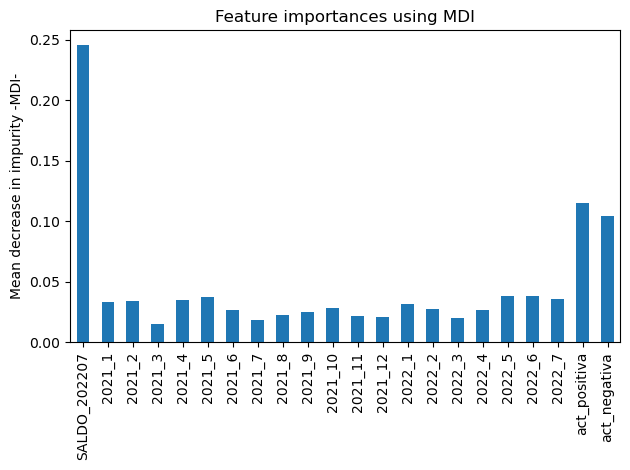

In [107]:
# Modelo con variables reducido

decision_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
decision_importances.plot.bar(ax=ax)

labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0]="SALDO_202207"
labels[1]="2021_1"
labels[2]="2021_2"
labels[3]="2021_3"
labels[4]="2021_4"
labels[5]="2021_5"
labels[6]="2021_6"
labels[7]="2021_7"
labels[8]="2021_8"
labels[9]="2021_9"
labels[10]="2021_10"
labels[11]="2021_11"
labels[12]="2021_12"
labels[13]="2022_1"
labels[14]="2022_2"
labels[15]="2022_3"
labels[16]="2022_4"
labels[17]="2022_5"
labels[18]="2022_6"
labels[19]="2022_7"
labels[20]="act_positiva"
labels[21]="act_negativa"

ax.set_xticklabels(labels)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity -MDI-")
fig.tight_layout()

In [128]:
preds1_decision = decision.predict(X_test)
print(accuracy_score(preds1_decision,y_test))

0.8517478948711406


In [112]:
# Cálculo del área bajo la curva ROC
score_decision = cross_val_score(decision, X_test, y_test, cv=10, scoring='roc_auc').mean()
score_decision

0.5723080151997172

**5.6.3 Random forest**

In [114]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=123)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [115]:
preds1_forest = forest.predict(X_test)
print(accuracy_score(preds1_forest,y_test))

0.9160500127583567


In [116]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

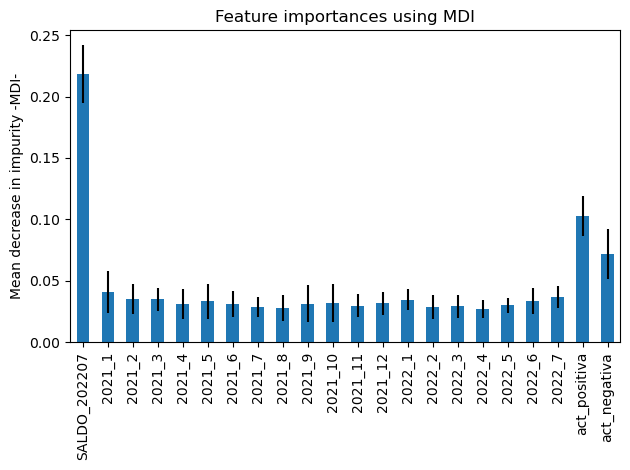

In [117]:
# Modelo con variables reducido

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

labels = [item.get_text() for item in ax.get_xticklabels()]

labels[0]="SALDO_202207"
labels[1]="2021_1"
labels[2]="2021_2"
labels[3]="2021_3"
labels[4]="2021_4"
labels[5]="2021_5"
labels[6]="2021_6"
labels[7]="2021_7"
labels[8]="2021_8"
labels[9]="2021_9"
labels[10]="2021_10"
labels[11]="2021_11"
labels[12]="2021_12"
labels[13]="2022_1"
labels[14]="2022_2"
labels[15]="2022_3"
labels[16]="2022_4"
labels[17]="2022_5"
labels[18]="2022_6"
labels[19]="2022_7"
labels[20]="act_positiva"
labels[21]="act_negativa"

ax.set_xticklabels(labels)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity -MDI-")
fig.tight_layout()

In [119]:
# Cálculo del área bajo la curva ROC
score_forest = cross_val_score(forest, X_test, y_test, cv=10, scoring='roc_auc').mean()
score_forest

0.677696073134231

**5.6.4 XGBOOST**

In [120]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
xgboost_model = XGBClassifier(random_state=123)
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [121]:
preds1_xgboost = xgboost_model.predict(X_test)
print(accuracy_score(preds1_xgboost,y_test))

0.9257463638683338


In [122]:
importances = xgboost_model.feature_importances_

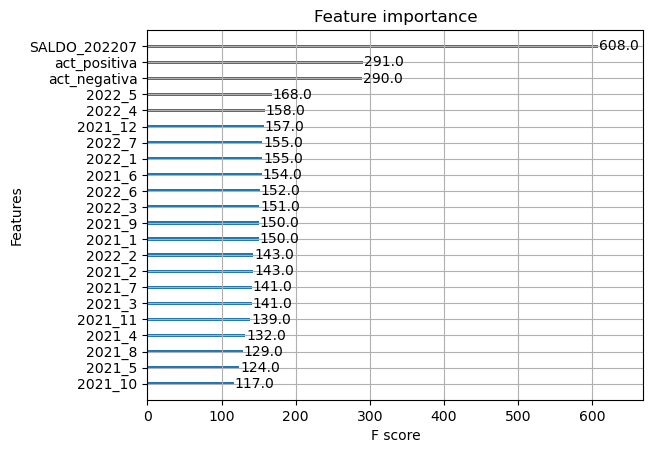

In [123]:
from matplotlib import pyplot

plot_importance(xgboost_model)
pyplot.show()

In [125]:
# Cálculo del área bajo la curva ROC
score_xgboost = cross_val_score(xgboost_model, X_test, y_test, cv=10, scoring='roc_auc').mean()
score_xgboost

0.7143678383115353

El modelo con mejores resultados corresponde al XGBOOST

In [ ]:
######################################